In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import cluster, manifold
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from umap.umap_ import UMAP
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import seaborn as sns

/Users/pedro/miniforge3/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Nulls

In [2]:
data = pd.read_csv('../data/water_potability.csv')
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [3]:
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [4]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [5]:
# fill the null values with the mean
data['ph'].fillna((data['ph'].mean()), inplace=True)
data['Sulfate'].fillna((data['Sulfate'].mean()), inplace=True)
data['Trihalomethanes'].fillna((data['Trihalomethanes'].mean()), inplace=True)


In [6]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [7]:
Y = data['Potability']
X = data.drop(columns=['Potability'])

# Outliers

In [8]:
data_minmax = MinMaxScaler().fit_transform(X.values)
pca = PCA(0.95, whiten=True)
data_pca = pca.fit_transform(X.values) 

In [9]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(data_pca)
scores = lof.negative_outlier_factor_

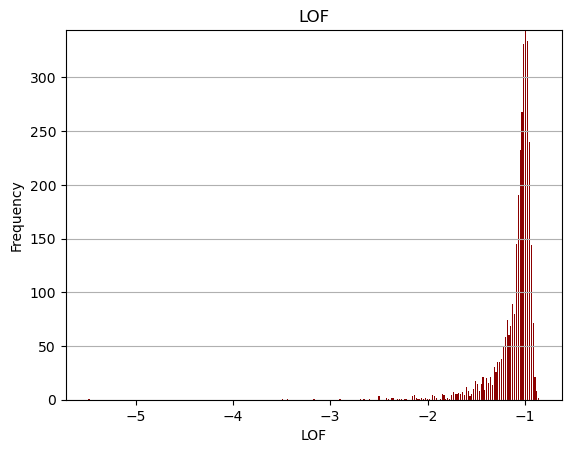

In [10]:
def plot_hist(X: pd.DataFrame, title: str) -> None:
    """ Funcion que genera un grafico de los valores de LOF del dataset """
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.65, color='darkred')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    
plot_hist(scores, 'LOF')

In [11]:
# Dado el grafico anterior, diremos que un umbral de corte sera aproximadamente -1.85
def lof_threshold(v: float, scores: np.ndarray) -> float:
    ''' Retorna la contaminacion del medio '''
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold 

lof_threshold(-2.5, scores) # APROXimadamente -2.5

0.0027472527472527475

In [12]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0027472527472527475)
labels = lof.fit_predict(X.values)
indices = list(np.where(labels==1)[0])
X = X.iloc[indices] # actualizamos la cant. de datos para ambos
Y = Y[indices]

In [13]:
print(X.shape, Y.shape)

(3267, 9) (3267,)


# Normalizacion


In [14]:
X_scaled = MinMaxScaler().fit_transform(X.values)

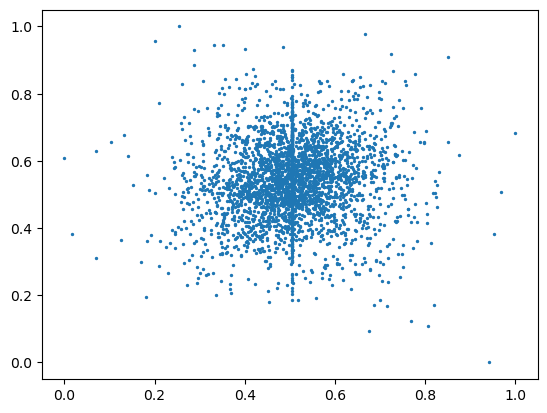

In [15]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=2)
plt.show()

# Hipermarametros SVM a utilizar


In [16]:
KERNELS = ['linear', 'poly', 'rbf', 'sigmoid'] 
DEGREES = [2, 3, 4, 5, 6] 
CVALUES = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100]  # limitamos a 100 por que toma mucho tiempo para valores mayores

# SVM (version hard)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, stratify=Y)

In [18]:

for kernel_ in KERNELS:
    for c in CVALUES:
        if kernel_ == 'poly':
            for degree_ in DEGREES:
                clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, degree= degree_, C=c))
                clf.fit(X_train, y_train)
                y_pred_sb = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred_sb)
                print(
                    "For kernel =",
                    kernel_,
                    "with degree =",
                    degree_,
                    "with C value = ",
                    c,
                    "The accuracy is :",
                    acc,
                )
        else:
            clf = make_pipeline(StandardScaler(), SVC(kernel=kernel_, C=c))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            print(
                "For kernel =",
                kernel_,
                "With C value = ",
                c,
                "The accuracy is :",
                acc,
            )

For kernel = linear With C value =  0.0001 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  0.001 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  0.01 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  0.1 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  1 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  10 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  20 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  50 The accuracy is : 0.6095820591233435
For kernel = linear With C value =  100 The accuracy is : 0.6095820591233435
For kernel = poly with degree = 2 with C value =  0.0001 The accuracy is : 0.6095820591233435
For kernel = poly with degree = 3 with C value =  0.0001 The accuracy is : 0.6095820591233435
For kernel = poly with degree = 4 with C value =  0.0001 The accuracy is : 0.6095820591233435
For kernel = poly with d

For kernel = rbf With C value =  10 The accuracy is : 0.6758409785932722


In [23]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.82      0.76       598
           1       0.62      0.45      0.52       383

    accuracy                           0.68       981
   macro avg       0.66      0.64      0.64       981
weighted avg       0.67      0.68      0.66       981



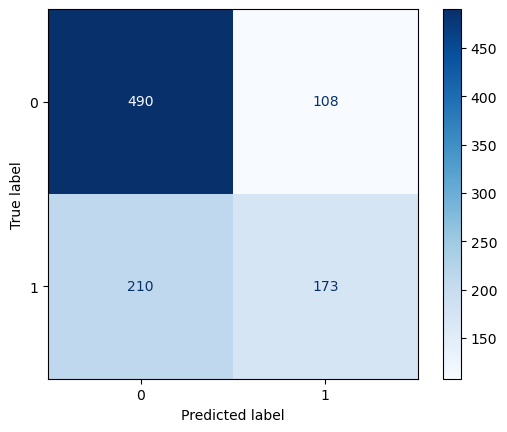

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')